## SRJ

## 2 Bonds breaking up symmetrical

In [1]:
from pyscf import gto, scf, cc

# Define the NH3 molecule in minimal basis set
mol = gto.Mole()
mol.atom = '''
N  0.000000  0.000000  0.000000
H  0.000000  0.000000  1.000000
H  0.000000  0.943000 -0.333000
H  0.000000 -0.943000 -0.333000
'''
mol.basis = 'sto-3g'  # Minimal basis set
mol.symmetry = True
mol.build()

#!/usr/bin/env python

'''
Using the CCSD method as the active space solver to compute an approximate
CASCI energy.

See also 42-oo_ccd.py

A wrapper is required to adapt the CCSD solver to CASCI fcisolver interface.
Inside the wrapper function, the CCSD code is the same as the example
40-ccsd_with_given_hamiltonian.py
'''

import numpy
from pyscf import gto, scf, cc, ao2mo, mcscf

class AsFCISolver(object):
    def __init__(self):
        self.mycc = None

    def kernel(self, h1, h2, norb, nelec, ci0=None, ecore=0, **kwargs):
        fakemol = gto.M(verbose=0)
        nelec = numpy.sum(nelec)
        fakemol.nelectron = nelec
        fake_hf = scf.RHF(fakemol)
        fake_hf._eri = ao2mo.restore(8, h2, norb)
        fake_hf.get_hcore = lambda *args: h1
        fake_hf.get_ovlp = lambda *args: numpy.eye(norb)
        fake_hf.kernel()
        self.mycc = cc.CCSD(fake_hf)
        eris = self.mycc.ao2mo()
        e_corr, t1, t2 = self.mycc.kernel(eris=eris)
        l1, l2 = self.mycc.solve_lambda(t1, t2, eris=eris)
        e_tot = self.mycc.e_tot + ecore
        eee,cee = self.mycc.eeccsd(nroots=15)
        print("----------------excited states",e_tot+eee)
        return e_tot, CCSDAmplitudesAsCIWfn([t1, t2, l1, l2])

    def make_rdm1(self, fake_ci, norb, nelec):
        t1, t2, l1, l2 = fake_ci.cc_amplitues
        dm1 = self.mycc.make_rdm1(t1, t2, l1, l2, ao_repr=True)
        return dm1

    def make_rdm12(self, fake_ci, norb, nelec):
        t1, t2, l1, l2 = fake_ci.cc_amplitues
        dm2 = self.mycc.make_rdm2(t1, t2, l1, l2, ao_repr=True)
        return self.make_rdm1(fake_ci, norb, nelec), dm2

    def spin_square(self, fake_ci, norb, nelec):
        return 0, 1

class CCSDAmplitudesAsCIWfn:
    def __init__(self, cc_amplitues):
        self.cc_amplitues = cc_amplitues

#Original : 'N 0 0 0; H 0 0 3.80; H 0.950353 0 -0.336000; H -0.475176 -0.823029 -0.336000',
r_bohr = 1.8897259886
mol = gto.M(atom = 'N 0 0 0; H 0 0 1.40; H 0 0.8 -0.336000; H 0.80 0.0 -0.336000',
            basis = 'sto3g',
            verbose = 1)
mf = scf.RHF(mol).run()

norb = 6
nelec = 6
mc = mcscf.CASCI(mf, norb, nelec)
mc.fcisolver = AsFCISolver()
mc.kernel()
#-55.224795269008006

----------------excited states [-55.10432372 -55.10432372 -55.10432372 -55.04006221 -54.97366363
 -54.97366363 -54.97366363 -54.82442676 -54.82442676 -54.82442675
 -54.80602378 -54.66678186 -54.66090107 -54.66090107 -54.63219733
 -54.63219733]


/opt/miniconda3/envs/adapt/lib/python3.13/site-packages/pyscf/gto/mole.py:1294: UserWarning: Function mol.dumps drops attribute _nelectron because it is not JSON-serializable
  warnings.warn(msg)


(np.float64(-55.31714410317606),
 np.float64(-10.933367515412442),
 array([[ 9.93386948e-01, -2.12909501e-01,  5.92136560e-17,
         -7.63612167e-02,  8.80593161e-02,  9.99456260e-02,
          9.27512601e-15, -1.42371341e-01],
        [ 3.34493726e-02,  6.86814928e-01, -3.96028300e-16,
          3.92909580e-01, -4.38386766e-01, -5.86860753e-01,
         -8.05269085e-14,  1.24494280e+00],
        [ 5.46310882e-03,  1.52194248e-01,  4.48546452e-01,
         -2.50207458e-01,  5.14885751e-01, -9.35894757e-02,
         -7.48086747e-01,  5.97869041e-01],
        [ 5.46310882e-03,  1.52194248e-01, -4.48546452e-01,
         -2.50207458e-01,  5.14885751e-01, -9.35894757e-02,
          7.48086747e-01,  5.97869041e-01],
        [-2.41041709e-03, -7.89017517e-02,  9.78501948e-16,
          4.61387074e-01,  4.46541539e-01, -7.01528131e-01,
          3.81607434e-14, -5.98577529e-01],
        [-3.21490600e-03,  5.59524821e-02,  5.03467246e-16,
          4.87620672e-01,  2.94344183e-01,  9.2955452

In [2]:
import numpy as np

ccsd_08_08 = np.array([-55.31714410317606, -55.10432372 -55.10432372 -55.10432372 -55.04006221 -54.97366363
 -54.97366363 -54.97366363 -54.82442676 -54.82442676 -54.82442675
 -54.80602378 -54.66678186 -54.66090107 -54.66090107 -54.63219733
 -54.63219733])

ccsd_10_10 = np.array([-55.43528164386988, -55.22063363 -55.22063363 -55.22063363 -55.13255165 -55.07635904
 -55.07635904 -55.07635903 -54.98302357 -54.98302356 -54.98302356
 -54.9626693  -54.9626693  -54.95939073 -54.95049545 -54.95049545
 -54.89383109])

ccsd_12_12 = np.array([-55.416793906801544, -55.19991148 -55.19991148 -55.19991148 -55.09347007 -55.08903907
 -55.089039   -55.089039   -55.08874588 -55.08874587 -55.08874587
 -55.04307326 -55.04307326 -55.00997193 -55.00997193 -55.00640027
 -54.99658664])


ccsd_14_14 = np.array([-55.35544864765327,-55.16038984 -55.16038984 -55.16038984 -55.13484287 -55.13484284
 -55.13484284 -55.11979448 -55.11979448 -55.04400893 -55.04297236
 -55.04297236 -55.03134297 -55.02742772 -55.02742772 -54.9843068
 -54.9843068  ])

ccsd_16_16 = np.array([-55.29143698143434, -55.17797613 -55.17797613 -55.17797613 -55.14785575 -55.14785559
 -55.14785559 -55.06724804 -55.06724804 -55.06724802 -55.05857291
 -55.05857291 -55.04259096 -55.04259096 -55.02921824 -55.0216727
 -54.96856593])

ccsd_18_18 = np.array([-55.24226230802821, -55.19689863 -55.19689862 -55.19689862 -55.14542723 -55.1454272
 -55.1454272  -55.11559251 -55.11559251 -55.04778362 -55.04778362
 -55.04778358 -55.03944443 -55.03944443 -55.03584102 -55.01284632
 -54.99400042])

ccsd_20_20 = np.array([-55.21687860138012, -55.22505955 -55.22505954 -55.22505954 -55.1493672  -55.1493672
 -55.1415131  -55.14151269 -55.14151269 -55.06920614 -55.06920614
 -55.06187119 -55.03186183 -55.03186183 -55.01090541 -55.01090541
 -54.98685033])

ccsd_22_22 = np.array([-55.20899002433477,-55.24969551 -55.24969551 -55.24969551 -55.16889924 -55.16889924
 -55.14654155 -55.14654155 -55.07196948 -55.07196948 -55.07092551
 -55.02533192 -55.02533192 -55.02533192 -55.02169121 -55.02169121
 -54.97582492 ])

ccsd_24_24 = np.array([-55.22088298798301,-55.29181073 -55.29181073 -55.29181072 -55.18515817 -55.18515817
 -55.15091105 -55.15091105 -55.05747807 -55.05747807 -55.05654103
 -55.05654103 -55.05316131 -55.05315996 -55.05315996 -55.03762064
 -54.98351719 ])

ccsd_26_26 = np.array([-55.22840682509083, -55.31374333 -55.31374333 -55.31374333 -55.19547978 -55.19547978
 -55.15527089 -55.15527089 -55.07207426 -55.07207426 -55.07163546
 -55.07163535 -55.07163535 -55.05003118 -55.05003118 -55.02833313
 -54.98759979])

ccsd_27_27 = np.array([-55.23160748761787, -55.32191509 -55.32191509 -55.32191509 -55.19946334 -55.19946334
 -55.1568099  -55.1568099  -55.07867892 -55.07867885 -55.07867885
 -55.07736858 -55.07736858 -55.04701701 -55.04701701 -55.02858986
 -54.98956129])

ccsd_28_28 = np.array([-55.08368897216668, -55.17875595 -55.17875595 -55.17875595 -55.17608256 -55.17608256
 -55.17608246 -55.1760033  -55.1760033  -55.1635344  -55.09617937
 -55.09617936 -55.09617936 -55.09261883 -55.0849481  -55.0849481
 -55.03613792])

ccsd_30_30 = np.array([-55.23876019355534, -55.33888237 -55.33888237 -55.33888237 -55.20809518 -55.20809518
 -55.15967353 -55.15967353 -55.09339256 -55.09339256 -55.09339245
 -55.08729169 -55.08729169 -55.03563406 -55.00612264 -54.9936566
 -54.9668222])

In [3]:
import numpy as np

ccsd_08_08n = np.array([-55.31714410317606, -55.10432372 , -55.04006221,-54.97366363, -54.82442676 , -54.80602378, -54.66678186 -54.66090107, -54.63219733])

ccsd_10_10n = np.array([-55.43528164386988, -55.22063363, -55.13255165, -55.07635904, -54.98302357, -54.9626693,  -54.95939073 -54.95049545,
 -54.89383109])

ccsd_12_12n = np.array([-55.416793906801544, -55.19991148, -55.09347007, -55.08903907, -55.08874588,-55.04307326, -55.00997193, -55.00640027,
 -54.99658664])


ccsd_14_14n = np.array([-55.35544864765327,-55.16038984, -55.13484287, -55.11979448 ,-55.04400893, -55.04297236 ,-55.03134297, -55.02742772, -54.9843068  ])






ccsd_16_16n = np.array([-55.29143698143434, -55.17797613, -55.14785575, -55.06724804,  -55.05857291, -55.04259096 , -55.0292182, -55.0216727,
 -54.96856593])

ccsd_18_18n = np.array([-55.24226230802821, -55.19689863,  -55.14542723,   -55.11559251,  -55.04778362 , -55.03944443 , -55.03584102, -55.01284632,
 -54.99400042])

ccsd_20_20n = np.array([-55.21687860138012, -55.22505955, -55.1493672, -55.1415131,  -55.0692061,-55.06187119, -55.03186183, -55.01090541,
 -54.98685033])

ccsd_22_22n = np.array([-55.20899002433477,-55.24969551, -55.16889924, -55.14654155, -55.07196948, -55.07092551, -55.02533192, -55.02169121, 
 -54.97582492 ])

ccsd_24_24n = np.array([-55.22088298798301,-55.29181073 , -55.18515817, -55.15091105,-55.05747807 , -55.05654103, -55.05316131, -55.03762064,
 -54.98351719 ])

ccsd_26_26n = np.array([-55.22840682509083, -55.31374333 , -55.19547978, -55.15527089, -55.07207426, -55.07163546, -55.05003118, -55.02833313,
 -54.98759979])


ccsd_27_27n = np.array([-55.23160748761787, -55.32191509 ,-55.19946334,-55.1568099,  -55.07867892 ,
 -55.07736858 , -55.04701701 , -55.02858986,
 -54.98956129])


ccsd_30_30n = np.array([-55.23876019355534, -55.33888237, -55.20809518, -55.15967353, -55.09339256, -55.08729169, -55.03563406, -55.00612264, -54.9936566,
 -54.9668222])



## FCI energies

In [4]:
import numpy as np

fenergies32 = np.array([-55.18139889, -55.18129467, -55.18119431, -55.18109097,
       -55.09552763, -55.09552696, -55.09552651, -55.09552562,
       -55.016928  , -55.01692735, -54.99331465, -54.99328745,
       -54.99327493, -54.99324728, -54.979221  , -54.97921915,
       -54.97903172, -54.97902699, -54.97898141, -54.97897926,
       -54.97878982, -54.97878966, -54.9340692 , -54.93406843,
       -54.93406656, -54.93406554, -54.87563174, -54.87562197,
       -54.87560821, -54.87559061, -54.87158682, -54.87158331,
       -54.8715088 , -54.87148915, -54.87130494, -54.87128168,
       -54.87120921, -54.87120467, -54.85357217, -54.85357215,
       -54.8534801 , -54.853477  , -54.85338679, -54.85338324,
       -54.85329506, -54.85329409, -54.83178393, -54.83178373,
       -54.83177976, -54.83177941, -54.8205195 , -54.82051921,
       -54.77138501, -54.77129059, -54.77119495, -54.77109993,
       -54.62209471, -54.62209311, -54.62057495, -54.6202187 ,
       -54.61052946, -54.60988591, -54.60979992, -54.60953031,
       -54.60452329, -54.60450985, -54.60408454, -54.60406713,
       -54.5938314 , -54.59357987, -54.59269183, -54.59259452,
       -54.58887537, -54.5888539 , -54.58790012, -54.58789083,
       -54.57326484, -54.57304814, -54.57282165, -54.57261834,
       -54.55623378, -54.55623366, -54.52463722, -54.52432557,
       -54.52427684, -54.52374301, -54.5228057 , -54.52276176,
       -54.52188251, -54.5218394 , -54.52183451, -54.52182062,
       -54.52173358, -54.52133751, -54.52127244, -54.52085819,
       -54.50750676, -54.50728142, -54.50654412, -54.50649821,
       -54.50518731, -54.50511778, -54.50431066, -54.50404405,
       -54.48954304, -54.48951528, -54.48937135, -54.48933439,
       -54.48239208, -54.48226241, -54.48224641, -54.48195906,
       -54.45409385, -54.45409259, -54.45409254, -54.45409012,
       -54.43848322, -54.43848128])

fenergies30 = np.array([-55.18159765, -55.18127483, -55.18097049, -55.18065409,
       -55.09533859, -55.09533684, -55.09533361, -55.09532734,
       -55.01680769, -55.01680606, -54.99328739, -54.99310292,
       -54.99301489, -54.99282974, -54.97935357, -54.97934774,
       -54.97901112, -54.97900257, -54.97871259, -54.97870978,
       -54.97836679, -54.97836677, -54.9338698 , -54.93386681,
       -54.93386574, -54.93386385, -54.87557063, -54.87549912,
       -54.8754041 , -54.87529288, -54.87176239, -54.8717563 ,
       -54.87162014, -54.87159361, -54.8710612 , -54.87102618,
       -54.87089295, -54.87088469, -54.8534342 , -54.85343302,
       -54.85327282, -54.85325691, -54.85310811, -54.85309144,
       -54.85295313, -54.85294502, -54.8316804 , -54.83167987,
       -54.83167581, -54.83167316, -54.82030285, -54.8203026 ,
       -54.77131451, -54.77114521, -54.77097282, -54.770802  ,
       -54.63098076, -54.6306812 , -54.628401  , -54.62759268,
       -54.62125941, -54.62041403, -54.61979421, -54.61930797,
       -54.61362634, -54.61359589, -54.61272094, -54.61268657,
       -54.60553737, -54.60513051, -54.60302708, -54.60288144,
       -54.59971741, -54.59966087, -54.59787763, -54.59784777,
       -54.57363065, -54.57303996, -54.57242576, -54.57186391,
       -54.55661101, -54.55661062, -54.53226192, -54.5319036 ,
       -54.53130554, -54.53011932, -54.52745004, -54.52735261,
       -54.52517878, -54.52506993, -54.52498017, -54.52437026,
       -54.52310561, -54.52256954, -54.52154512, -54.52153458,
       -54.51486207, -54.51485004, -54.51449332, -54.51417959,
       -54.51087115, -54.51086211, -54.5105728 , -54.51031248,
       -54.49127511, -54.49124384, -54.49122429, -54.4904772 ,
       -54.48902655, -54.48900708, -54.48881047, -54.48877472,
       -54.4541608 , -54.45413258, -54.45411347, -54.45410656,
       -54.44514097, -54.44513485])

fenergies28 = np.array([-55.18215303, -55.18130274, -55.18053744, -55.17972278,
       -55.09497765, -55.09497385, -55.09495472, -55.09492016,
       -55.01659793, -55.01659466, -54.99336236, -54.99278037,
       -54.99250626, -54.99192592, -54.97970093, -54.9796838 ,
       -54.97907582, -54.97905869, -54.97814441, -54.97814106,
       -54.97751115, -54.97751086, -54.93348072, -54.93347679,
       -54.9334698 , -54.93346171, -54.87551372, -54.87533113,
       -54.87502606, -54.87465153, -54.87220135, -54.87219252,
       -54.87193071, -54.87189884, -54.87057495, -54.87052293,
       -54.87025921, -54.8702454 , -54.85316047, -54.8531504 ,
       -54.85286929, -54.85279075, -54.85257045, -54.85249249,
       -54.85232127, -54.85227535, -54.83146935, -54.83146702,
       -54.8314628 , -54.83145291, -54.81985324, -54.81985024,
       -54.77119148, -54.77087879, -54.77055959, -54.77024378,
       -54.64068243, -54.63955941, -54.63637072, -54.63449809,
       -54.63340289, -54.63281167, -54.63069651, -54.62978969,
       -54.62361774, -54.62356695, -54.62181026, -54.62164524,
       -54.61954522, -54.61835059, -54.6142252 , -54.61391604,
       -54.61210801, -54.61201183, -54.60920876, -54.60912107,
       -54.57490625, -54.57342604, -54.57189135, -54.57047647,
       -54.55744707, -54.55744624, -54.54059054, -54.53978465,
       -54.53969103, -54.53693536, -54.53240488, -54.53182375,
       -54.53137909, -54.53090747, -54.53086267, -54.53025788,
       -54.52766969, -54.5259206 , -54.5236922 , -54.5233888 ,
       -54.5209777 , -54.52095414, -54.51810741, -54.51677287,
       -54.51393803, -54.51354251, -54.51349337, -54.51339929,
       -54.50126803, -54.5012161 , -54.50082853, -54.49950376,
       -54.48802191, -54.48800958, -54.48769054, -54.48763952,
       -54.45527839, -54.4549348 , -54.45464262, -54.45452237,
       -54.45110282, -54.45108378])

fenergies26 = np.array([-55.18352078, -55.18141977, -55.17968917, -55.17775781,
       -55.09425417, -55.09424927, -55.09414943, -55.09398577,
       -55.01620407, -55.0162017 , -54.99372919, -54.99219759,
       -54.99150256, -54.9899951 , -54.98047246, -54.98042637,
       -54.9793632 , -54.97932387, -54.9769126 , -54.97690954,
       -54.97576297, -54.97576289, -54.93265488, -54.93263869,
       -54.9326313 , -54.93257451, -54.87546134, -54.87520829,
       -54.87439163, -54.87326302, -54.87318382, -54.87318275,
       -54.87268248, -54.87265175, -54.86959214, -54.86951581,
       -54.86897068, -54.86894822, -54.85258859, -54.85252809,
       -54.8520542 , -54.85169013, -54.85150725, -54.85118839,
       -54.85115912, -54.85096664, -54.83100294, -54.83099338,
       -54.83095371, -54.83093913, -54.81885289, -54.81882116,
       -54.7709488 , -54.77036147, -54.76976684, -54.76917645,
       -54.65114129, -54.64881353, -54.64785104, -54.64700639,
       -54.6444657 , -54.64273771, -54.64109035, -54.63971946,
       -54.63646227, -54.63490225, -54.63453301, -54.63350708,
       -54.63061462, -54.62974208, -54.62609755, -54.62482115,
       -54.62439253, -54.62403797, -54.6217715 , -54.6215362 ,
       -54.57822456, -54.57478844, -54.57126713, -54.56793876,
       -54.55920821, -54.55916982, -54.54842578, -54.5479887 ,
       -54.54610051, -54.54206652, -54.54197818, -54.53990701,
       -54.53988483, -54.53842193, -54.53549915, -54.53273927,
       -54.53218869, -54.53213434, -54.53160638, -54.53110553,
       -54.51993523, -54.51993305, -54.51951191, -54.51603221,
       -54.51397615, -54.51383607, -54.51380455, -54.51243774,
       -54.51177207, -54.51167122, -54.5107406 , -54.50853461,
       -54.48637525, -54.486356  , -54.48581386, -54.48568155,
       -54.4612542 , -54.45932764, -54.45709587, -54.45636211,
       -54.45498716, -54.45480492])

fenergies24 = np.array([-55.18677115, -55.18167834, -55.17808844, -55.17369976,
       -55.09279945, -55.09278893, -55.0923294 , -55.09165362,
       -55.01549091, -55.01546666, -54.99495106, -54.99116434,
       -54.98958114, -54.98596431, -54.98202025, -54.98191955,
       -54.98022124, -54.98011975, -54.97423939, -54.97423601,
       -54.97221834, -54.97221197, -54.9308146 , -54.93075611,
       -54.93070794, -54.930507  , -54.87569464, -54.8754497 ,
       -54.87543183, -54.87529657, -54.87445208, -54.87437265,
       -54.87345212, -54.87028504, -54.86762649, -54.86750738,
       -54.86637001, -54.86633045, -54.85139571, -54.85109071,
       -54.85040175, -54.84941333, -54.84938433, -54.84886834,
       -54.84842   , -54.84798138, -54.82991483, -54.82987269,
       -54.82968314, -54.82965929, -54.81650886, -54.81628519,
       -54.77046636, -54.76935007, -54.76825997, -54.76715904,
       -54.67130308, -54.66345743, -54.66248539, -54.65747408,
       -54.65607218, -54.65601779, -54.65363918, -54.65188595,
       -54.64746667, -54.64631725, -54.64379977, -54.64100094,
       -54.64059739, -54.63957278, -54.63666541, -54.63480964,
       -54.63270107, -54.63264112, -54.63134397, -54.63120664,
       -54.5844778 , -54.57728365, -54.57054098, -54.56346434,
       -54.56274796, -54.56239477, -54.55758847, -54.55352521,
       -54.55249928, -54.54912624, -54.54868103, -54.54839531,
       -54.54444557, -54.54383004, -54.54133297, -54.53876158,
       -54.53624878, -54.53618175, -54.53484103, -54.53406243,
       -54.52205752, -54.52184103, -54.51892858, -54.51844575,
       -54.51660116, -54.51627593, -54.51537294, -54.51369376,
       -54.51361674, -54.51337475, -54.51019806, -54.50798449,
       -54.48388513, -54.48374072, -54.48285723, -54.48237855,
       -54.46929341, -54.46657505, -54.46198231, -54.461275  ,
       -54.45935124, -54.45867825])

fenergies22 = np.array([-55.19432771, -55.18204734, -55.17529625, -55.1654942 ,
       -55.08995183, -55.0898324 , -55.08793542, -55.08557246,
       -55.01441595, -55.01421668, -54.99866599, -54.98939255,
       -54.98610423, -54.98476222, -54.98458495, -54.98238975,
       -54.98215213, -54.97774389, -54.96851793, -54.96848624,
       -54.9651272 , -54.96507572, -54.92660636, -54.92643904,
       -54.92603254, -54.92555447, -54.88006214, -54.88003591,
       -54.87878927, -54.87858955, -54.87784617, -54.87484986,
       -54.8728128 , -54.86413227, -54.86375427, -54.86329017,
       -54.861253  , -54.86117432, -54.84893147, -54.84757632,
       -54.84715712, -54.84703505, -54.845304  , -54.8434769 ,
       -54.84154821, -54.84018126, -54.82725694, -54.82718013,
       -54.82642676, -54.82635984, -54.8107465 , -54.80954673,
       -54.76953738, -54.76736969, -54.76545328, -54.76341898,
       -54.7012377 , -54.68449402, -54.68136178, -54.67624142,
       -54.67238988, -54.66681146, -54.66213772, -54.65824119,
       -54.657396  , -54.65366641, -54.6531765 , -54.65120537,
       -54.64761071, -54.64239457, -54.63924679, -54.63690901,
       -54.63560501, -54.63439612, -54.62988113, -54.62837697,
       -54.59250922, -54.57901886, -54.57029537, -54.56857024,
       -54.5666666 , -54.56653538, -54.56210382, -54.55791924,
       -54.55652132, -54.55529048, -54.55358896, -54.55190428,
       -54.54980174, -54.54817458, -54.54344134, -54.54295406,
       -54.5389656 , -54.53595981, -54.53594733, -54.53581708,
       -54.52910608, -54.52240339, -54.52083097, -54.51350646,
       -54.5134238 , -54.51310116, -54.51260783, -54.51235712,
       -54.5067682 , -54.5047898 , -54.50188635, -54.49873105,
       -54.4838188 , -54.48073939, -54.48045836, -54.47987666,
       -54.47792726, -54.47667738, -54.47385287, -54.46936793,
       -54.46090253, -54.45910723])

fenergies20 = np.array([-55.21128653, -55.18258871, -55.17151311, -55.14970453,
       -55.08504194, -55.08441954, -55.07728985, -55.07079347,
       -55.01426548, -55.0133032 , -55.00906773, -54.98933643,
       -54.98818107, -54.98676821, -54.98668748, -54.98668009,
       -54.98067038, -54.9616697 , -54.95678614, -54.95661514,
       -54.95147252, -54.95120586, -54.91791225, -54.91727033,
       -54.91554751, -54.9147374 , -54.88992568, -54.88933576,
       -54.88840035, -54.88801063, -54.88324711, -54.87380746,
       -54.87324974, -54.85651402, -54.85648586, -54.85192171,
       -54.85176233, -54.85034635, -54.84586075, -54.84438514,
       -54.84072763, -54.83908352, -54.83798287, -54.83467943,
       -54.82493569, -54.82319205, -54.82145086, -54.82116954,
       -54.81906265, -54.81883453, -54.79764658, -54.79328671,
       -54.7683364 , -54.76406765, -54.76104754, -54.7574875 ,
       -54.73718345, -54.71302553, -54.70008974, -54.6930183 ,
       -54.6828658 , -54.67438234, -54.66990436, -54.66870585,
       -54.66408526, -54.66317429, -54.6535829 , -54.64802263,
       -54.63989481, -54.63904127, -54.63311292, -54.63239686,
       -54.62956143, -54.61411378, -54.61394588, -54.6097859 ,
       -54.59904112, -54.58242056, -54.57602881, -54.57534984,
       -54.57313935, -54.5703025 , -54.57011075, -54.56385946,
       -54.55991951, -54.55957661, -54.556327  , -54.55196446,
       -54.55147384, -54.54801347, -54.54543891, -54.53662709,
       -54.53086428, -54.52620156, -54.5260777 , -54.52538604,
       -54.521716  , -54.52037884, -54.51270919, -54.51136467,
       -54.5112136 , -54.50655311, -54.50645977, -54.50518364,
       -54.50471544, -54.499726  , -54.48930945, -54.48710791,
       -54.48385488, -54.48280308, -54.48117873, -54.47616987,
       -54.47439305, -54.46960803, -54.46871975, -54.4676657 ,
       -54.4647017 , -54.46272858])

fenergies18 = np.array([-55.24328841, -55.18173739, -55.16697732, -55.11992461,
       -55.07732072, -55.07466193, -55.0514444 , -55.03824644,
       -55.03145944, -55.01904387, -55.01684793, -54.9958837 ,
       -54.99330342, -54.9890622 , -54.98888196, -54.9819594 ,
       -54.97260271, -54.93327595, -54.93285257, -54.93092118,
       -54.9255866 , -54.92450104, -54.90918763, -54.908047  ,
       -54.90649453, -54.90598334, -54.90307072, -54.89734278,
       -54.89315305, -54.89210793, -54.88410439, -54.87181452,
       -54.86781454, -54.8438112 , -54.84373936, -54.8429066 ,
       -54.83545346, -54.8351416 , -54.83510853, -54.82818616,
       -54.82459399, -54.82220312, -54.81873605, -54.81743385,
       -54.80949859, -54.80914824, -54.80326476, -54.80285114,
       -54.79022919, -54.78719617, -54.7754887 , -54.76848526,
       -54.76670265, -54.75816981, -54.75789558, -54.75415587,
       -54.74753574, -54.74556777, -54.70999304, -54.69844584,
       -54.68680818, -54.6752251 , -54.67215808, -54.66908662,
       -54.6615414 , -54.65820098, -54.64238626, -54.63963012,
       -54.62030351, -54.62014359, -54.61027565, -54.61014284,
       -54.60499305, -54.60382967, -54.59793438, -54.59364043,
       -54.58163808, -54.58088861, -54.57471742, -54.57435282,
       -54.57393522, -54.57157743, -54.56854426, -54.5657138 ,
       -54.56407294, -54.55598457, -54.55319861, -54.53551107,
       -54.53517106, -54.53318084, -54.53108825, -54.52382113,
       -54.52303452, -54.5215135 , -54.52004165, -54.51280928,
       -54.51184771, -54.50392807, -54.5014295 , -54.50000857,
       -54.49890209, -54.49494478, -54.49246755, -54.48950734,
       -54.48886715, -54.4863609 , -54.48430876, -54.47708244,
       -54.4735743 , -54.47083351, -54.46883791, -54.46624374,
       -54.45989671, -54.45890608, -54.45550846, -54.45473987,
       -54.45177315, -54.45135579])

fenergies16 = np.array([-55.29326421, -55.17578677, -55.15996326, -55.07776934,
       -55.06641163, -55.06187211, -55.06000661, -55.03060174,
       -55.02927033, -54.99751509, -54.99628085, -54.99556667,
       -54.98711404, -54.98603234, -54.97199004, -54.97085627,
       -54.96021465, -54.94093991, -54.93640957, -54.93404247,
       -54.92281549, -54.89550544, -54.88816314, -54.88734454,
       -54.87907593, -54.87637649, -54.87420115, -54.87219776,
       -54.86680911, -54.85786265, -54.85105716, -54.84586077,
       -54.83435264, -54.82679397, -54.8252088 , -54.81874052,
       -54.81339554, -54.81015768, -54.80815589, -54.80811663,
       -54.80310954, -54.80033423, -54.79155108, -54.78881834,
       -54.78565409, -54.78331703, -54.77210731, -54.76703599,
       -54.76625596, -54.76300367, -54.76266785, -54.74806356,
       -54.74384969, -54.73420146, -54.7241477 , -54.72051404,
       -54.7102931 , -54.69653266, -54.69054105, -54.68362953,
       -54.67874348, -54.66096416, -54.65405863, -54.65196963,
       -54.6369148 , -54.63562112, -54.62750731, -54.62011742,
       -54.6082348 , -54.60137356, -54.59854247, -54.58648564,
       -54.58637193, -54.58634083, -54.58254759, -54.57651445,
       -54.56821372, -54.56540516, -54.55927066, -54.55399823,
       -54.54976677, -54.54686617, -54.541968  , -54.53927754,
       -54.53519614, -54.53471078, -54.5284003 , -54.51692754,
       -54.51668231, -54.51061858, -54.50199234, -54.50148854,
       -54.48689423, -54.48474255, -54.48348062, -54.4772579 ,
       -54.47425486, -54.47081653, -54.46834514, -54.46409032,
       -54.46162741, -54.4612846 , -54.45995505, -54.4591684 ,
       -54.45637257, -54.44990554, -54.44814965, -54.44476285,
       -54.44153702, -54.43949735, -54.43491412, -54.43456494,
       -54.43301205, -54.43140786, -54.4313454 , -54.4300206 ,
       -54.42747822, -54.42080353])

fenergies14 = np.array([-55.35663927, -55.16242228, -55.14121687, -55.12517547,
       -55.05148434, -55.04446868, -55.04385222, -55.03184004,
       -55.01077337, -54.99028867, -54.98966921, -54.97754337,
       -54.97360708, -54.97245993, -54.96376613, -54.93826074,
       -54.93701567, -54.93430283, -54.92192322, -54.89531133,
       -54.86914808, -54.86301632, -54.8476321 , -54.82823536,
       -54.82620386, -54.82172812, -54.81886684, -54.81481458,
       -54.80399844, -54.79961093, -54.79129974, -54.78132063,
       -54.77733371, -54.77711846, -54.77540874, -54.77203124,
       -54.76891937, -54.76594686, -54.7626625 , -54.76051907,
       -54.75525891, -54.7514682 , -54.74380106, -54.74247787,
       -54.73927339, -54.73430941, -54.7311369 , -54.72114245,
       -54.72009888, -54.72005868, -54.709111  , -54.70770204,
       -54.67333878, -54.66170827, -54.66002768, -54.64517804,
       -54.63101674, -54.62230184, -54.6178491 , -54.60973279,
       -54.60766765, -54.60509431, -54.60133804, -54.60125277,
       -54.59737893, -54.59651229, -54.5906043 , -54.58876136,
       -54.57509203, -54.56263388, -54.55266799, -54.55074059,
       -54.54778452, -54.53820542, -54.5350404 , -54.53250231,
       -54.53059571, -54.52512821, -54.51225876, -54.49962497,
       -54.49442478, -54.49412202, -54.4933135 , -54.48103438,
       -54.47676109, -54.4685437 , -54.46719449, -54.46700738,
       -54.46562657, -54.45985899, -54.45727597, -54.45598923,
       -54.44697604, -54.44602322, -54.43740614, -54.43351087,
       -54.43306534, -54.4304957 , -54.42960058, -54.42556162,
       -54.41794804, -54.40370139, -54.40221656, -54.40219761,
       -54.39098054, -54.39095019, -54.38894376, -54.38180308,
       -54.37749944, -54.37532064, -54.37496017, -54.36590666,
       -54.36484964, -54.36317375, -54.36143904, -54.36126348,
       -54.35676764, -54.35146433])

fenergies12 = np.array([-55.41741711, -55.20225978, -55.09374249, -55.09278961,
       -55.0917552 , -55.04513975, -55.01472464, -55.01433125,
       -55.00079069, -54.99946251, -54.98228556, -54.97316461,
       -54.90442225, -54.89477127, -54.89401429, -54.88402483,
       -54.87567212, -54.87094412, -54.81458378, -54.79880084,
       -54.79830718, -54.79610802, -54.79418823, -54.76616648,
       -54.75971777, -54.75356052, -54.73331755, -54.72022214,
       -54.71495971, -54.70636342, -54.70497273, -54.69789998,
       -54.69348664, -54.69070407, -54.68401928, -54.68333631,
       -54.67756889, -54.67170646, -54.65973745, -54.64341456,
       -54.63905047, -54.63726235, -54.62852904, -54.62602271,
       -54.6196767 , -54.61919794, -54.60196649, -54.60018483,
       -54.59957542, -54.59038224, -54.58846368, -54.58149732,
       -54.57650451, -54.56042592, -54.55641759, -54.54914293,
       -54.54649208, -54.5391346 , -54.53524881, -54.53137807,
       -54.53001498, -54.50612156, -54.493887  , -54.49067312,
       -54.48147968, -54.47914912, -54.47904476, -54.47580026,
       -54.46488025, -54.46314386, -54.45599369, -54.44915456,
       -54.44736366, -54.4447845 , -54.43069551, -54.43058804,
       -54.42469635, -54.41850137, -54.41422256, -54.4099511 ,
       -54.39863942, -54.39840529, -54.3972402 , -54.39665664,
       -54.39434042, -54.38539706, -54.37829182, -54.37719742,
       -54.36784905, -54.35975783, -54.35904877, -54.33608545,
       -54.33367336, -54.32930602, -54.32784594, -54.32503177,
       -54.32392082, -54.31956947, -54.31128832, -54.30070174,
       -54.28878721, -54.28140854, -54.27804461, -54.27658544,
       -54.27530627, -54.2670726 , -54.26266055, -54.26027721,
       -54.25572172, -54.25464312, -54.25032717, -54.24551314,
       -54.2453343 , -54.23872021, -54.23354263, -54.22649176,
       -54.22621887, -54.21033615])

fenergies10 = np.array([-55.43557607, -55.22185779, -55.13277323, -55.07686048,
       -54.98866907, -54.96616113, -54.96452045, -54.95195273,
       -54.89533781, -54.88488497, -54.85003737, -54.82550335,
       -54.82497112, -54.74919583, -54.74173862, -54.72825243,
       -54.72489871, -54.72324627, -54.70968883, -54.66900329,
       -54.65319693, -54.63687202, -54.62819971, -54.62324431,
       -54.6107401 , -54.61025648, -54.60427722, -54.58817512,
       -54.57330819, -54.55666467, -54.55566028, -54.55266684,
       -54.54559035, -54.54330996, -54.53507845, -54.52559797,
       -54.51938453, -54.51247576, -54.50149283, -54.48768614,
       -54.47791061, -54.47575412, -54.46599495, -54.46568143,
       -54.4455727 , -54.43804835, -54.4227307 , -54.40423293,
       -54.39518022, -54.39331157, -54.38258456, -54.38021141,
       -54.37528987, -54.36802708, -54.36686052, -54.35346193,
       -54.35119729, -54.34631095, -54.33194612, -54.33171268,
       -54.32430411, -54.32181396, -54.31373137, -54.30933944,
       -54.3035566 , -54.30154272, -54.29210314, -54.27667436,
       -54.27304518, -54.26926407, -54.26885105, -54.26252733,
       -54.25291093, -54.24453444, -54.24268383, -54.22839221,
       -54.22018728, -54.20335293, -54.191913  , -54.18895405,
       -54.18329653, -54.17124056, -54.15299531, -54.14831846,
       -54.14521634, -54.14227133, -54.1391879 , -54.12514433,
       -54.12063271, -54.11629553, -54.11503903, -54.10480735,
       -54.08615825, -54.08537971, -54.08046998, -54.06839323,
       -54.06576731, -54.06224492, -54.05742196, -54.05516517,
       -54.047783  , -54.04397562, -54.03513971, -54.03241614,
       -54.02783561, -54.026255  , -54.01605194, -54.01225659,
       -54.01072864, -54.00356301, -53.99743538, -53.98887291,
       -53.98389877, -53.97826167, -53.97767145, -53.9745641 ,
       -53.97455312, -53.9534291 ])

fenergies08 = np.array([-55.31728482, -55.10493898, -55.04037229, -54.9738492 ,
       -54.82781694, -54.80985782, -54.66865219, -54.66211199,
       -54.63301722, -54.59319627, -54.5667532 , -54.49556698,
       -54.46980753, -54.46290644, -54.4277783 , -54.41000747,
       -54.39717137, -54.39451041, -54.3747799 , -54.37362337,
       -54.3681664 , -54.33738064, -54.33441356, -54.32083821,
       -54.30983795, -54.29763032, -54.29366228, -54.27680997,
       -54.26516179, -54.26493397, -54.25727398, -54.25599484,
       -54.23986768, -54.22140412, -54.21179   , -54.21080319,
       -54.20663264, -54.20154855, -54.19751548, -54.1859483 ,
       -54.18317853, -54.16482783, -54.1423932 , -54.13735892,
       -54.1336317 , -54.13287178, -54.11613802, -54.11284084,
       -54.11130818, -54.08153829, -54.07277225, -54.05588537,
       -54.03294923, -54.03232899, -54.02308306, -54.01644136,
       -54.00701467, -53.98670348, -53.96530371, -53.961974  ,
       -53.95541415, -53.92304185, -53.92255456, -53.92140617,
       -53.89345598, -53.89176456, -53.85103365, -53.83356575,
       -53.82995177, -53.82486708, -53.82219547, -53.80683144,
       -53.79683972, -53.78158485, -53.77688279, -53.77541402,
       -53.77219158, -53.76867196, -53.76534362, -53.76401252,
       -53.70797411, -53.70466158, -53.70408966, -53.69130426,
       -53.67047104, -53.66522337, -53.66147527, -53.64835399,
       -53.64684997, -53.6405569 , -53.63622896, -53.63186035,
       -53.59752818, -53.58699057, -53.58150061, -53.57076392,
       -53.56946069, -53.56905913, -53.56571079, -53.5652434 ,
       -53.55636413, -53.55038594, -53.54914279, -53.54657992,
       -53.53088621, -53.52846555, -53.52838278, -53.52741732,
       -53.52578022, -53.51812001, -53.51730796, -53.51012649,
       -53.50344464, -53.49871767, -53.48496387, -53.48268546,
       -53.47918328, -53.47646925])

fenergies05 = np.array([-54.30773107, -54.0824388 , -54.05002886, -53.98336498,
       -53.80634255, -53.78842047, -53.6593593 , -53.40859282,
       -53.33516961, -53.25614384, -53.23641475, -53.17354907,
       -53.15169864, -53.14910127, -53.13390781, -53.13191861,
       -53.11041899, -53.08221702, -53.05128985, -52.99726165,
       -52.97189591, -52.95238664, -52.94273745, -52.92941986,
       -52.91855857, -52.89149951, -52.88544196, -52.88042126,
       -52.85484559, -52.83446848, -52.82341752, -52.82177001,
       -52.81698409, -52.79595173, -52.77550783, -52.76881123,
       -52.76790301, -52.75870466, -52.73497639, -52.71224647,
       -52.71168995, -52.71098835, -52.70244945, -52.69584292,
       -52.68000779, -52.67511943, -52.67431691, -52.67293165,
       -52.66159792, -52.65732821, -52.65386831, -52.61217596,
       -52.61095215, -52.60526791, -52.58695196, -52.56170721,
       -52.56011763, -52.51317511, -52.51003416, -52.50931206,
       -52.46918468, -52.46300206, -52.45320205, -52.42839154,
       -52.41269007, -52.38853828, -52.37540581, -52.35288153,
       -52.34568818, -52.34518091, -52.31675815, -52.30966292,
       -52.28738548, -52.27303096, -52.24963216, -52.14618063,
       -52.14472701, -52.1306358 , -52.09994683, -52.09584097,
       -52.0467244 , -52.02825282, -52.01317865, -52.00561856,
       -51.98881665, -51.98507386, -51.98456347, -51.97921574,
       -51.97330404, -51.95003833, -51.94384984, -51.93184884,
       -51.92383895, -51.91266519, -51.91048451, -51.89358264,
       -51.89233594, -51.88522293, -51.8839741 , -51.84543004,
       -51.83989871, -51.81075285, -51.80650542, -51.79239063,
       -51.77921433, -51.77506841, -51.76447382, -51.75981141,
       -51.74951077, -51.73746013, -51.73533715, -51.72833539,
       -51.72492662, -51.71538086, -51.7092113 , -51.70920454,
       -51.69551823, -51.65940272])

In [5]:
from pyscf import gto, scf, mcscf
import numpy as np
#coordinates = np.array([[0.0,0.0, 0.0], [0.0, 0.0, 1.20*r_bohr], [1.20*r_bohr,0.0,-0.336000*r_bohr],[-0.475176*r_bohr, -0.823029*r_bohr, -0.336000*r_bohr]])

# Define the molecule
mol = gto.M(
    atom='N 0 0 0; H 0 0 1.40; H 0 2.70 -0.336000; H 2.70 0.0 -0.336000',
    basis='sto-3g',
    verbose=1  # Optional: Adjusts verbosity for output
)
 
# Perform Restricted Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()
 
# Get the HF energy
hf_energy = mf.e_tot
print("Hartree-Fock Ground State Energy:", hf_energy)
 
# Define the active space
ncas = 6  # Number of active orbitals - spatial it seems
nelecas = 6  # Number of electrons in the active space
 
# Set up the CASCI/CASSCF solver
mycas = mcscf.CASCI(mf, ncas, nelecas)
 
 
mycas.fcisolver.nroots=118
 
# Compute the CASCI/CASSCF energy
e_casci = mycas.kernel()
 
# Output the results
print("CASCI/CASSCF Ground State Energy:", e_casci)
print("Hartree-Fock Ground State Energy:", hf_energy)

Hartree-Fock Ground State Energy: -54.63708860486406
CASCI/CASSCF Ground State Energy: (array([-55.18268984, -55.18134718, -55.18018333, -55.17891976,
       -55.0946793 , -55.09467445, -55.09463012, -55.09455364,
       -55.01643264, -55.01642893, -54.99348834, -54.992532  ,
       -54.99208818, -54.99113948, -54.98001544, -54.97998688,
       -54.97917734, -54.97915185, -54.97764684, -54.97764349,
       -54.97679151, -54.97679114, -54.93314777, -54.93314091,
       -54.93313205, -54.9331082 , -54.87548764, -54.8752485 ,
       -54.87474146, -54.87408956, -54.87259981, -54.87259112,
       -54.87222722, -54.87219494, -54.87016901, -54.87010602,
       -54.86972824, -54.86971064, -54.85292738, -54.85290201,
       -54.85253357, -54.85236287, -54.85212927, -54.8519632 ,
       -54.85183251, -54.85173011, -54.83128269, -54.83128094,
       -54.83126416, -54.83125219, -54.81945546, -54.81944483,
       -54.77109155, -54.77066367, -54.77022777, -54.76979617,
       -54.64581151, -54.64386

In [6]:
fenergies27 = np.array([-55.18268984, -55.18134718, -55.18018333, -55.17891976,
       -55.0946793 , -55.09467445, -55.09463012, -55.09455364,
       -55.01643264, -55.01642893, -54.99348834, -54.992532  ,
       -54.99208818, -54.99113948, -54.98001544, -54.97998688,
       -54.97917734, -54.97915185, -54.97764684, -54.97764349,
       -54.97679151, -54.97679114, -54.93314777, -54.93314091,
       -54.93313205, -54.9331082 , -54.87548764, -54.8752485 ,
       -54.87474146, -54.87408956, -54.87259981, -54.87259112,
       -54.87222722, -54.87219494, -54.87016901, -54.87010602,
       -54.86972824, -54.86971064, -54.85292738, -54.85290201,
       -54.85253357, -54.85236287, -54.85212927, -54.8519632 ,
       -54.85183251, -54.85173011, -54.83128269, -54.83128094,
       -54.83126416, -54.83125219, -54.81945546, -54.81944483,
       -54.77109155, -54.77066367, -54.77022777, -54.76979617,
       -54.64581151, -54.64386628, -54.6403458 , -54.64017901,
       -54.64002279, -54.63742961, -54.63653446, -54.63530092,
       -54.62904681, -54.62894763, -54.6276118 , -54.62698246,
       -54.62613714, -54.62478418, -54.62008606, -54.61945745,
       -54.61844272, -54.61842239, -54.61538322, -54.61523645,
       -54.57622602, -54.57394467, -54.57158564, -54.5693946 ,
       -54.55816854, -54.55816019, -54.54448655, -54.5440166 ,
       -54.54325803, -54.53979618, -54.53695973, -54.53550714,
       -54.53523587, -54.5346614 , -54.53297186, -54.53221747,
       -54.53050972, -54.52869696, -54.52805307, -54.52743715,
       -54.52052879, -54.52049937, -54.51883178, -54.51661492,
       -54.51426468, -54.51392564, -54.51383582, -54.51334899,
       -54.50655059, -54.50651423, -54.50580157, -54.50407762,
       -54.48729191, -54.48728077, -54.48686474, -54.48678826,
       -54.45754862, -54.45650609, -54.45555126, -54.45518835,
       -54.45338636, -54.45334976])

In [7]:
ccsd_27_27n[0]

np.float64(-55.23160748761787)

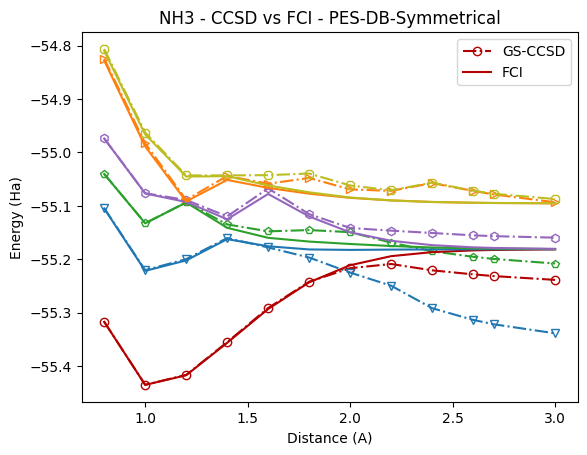

In [8]:
import matplotlib.pyplot as plt

distance = np.array([0.8,1.0, 1.2, 1.4, 1.6,1.8,2.0,2.2,2.4,2.6,2.7, 3.0])

CCSD_GS = np.array([ccsd_08_08n[0], ccsd_10_10n[0], ccsd_12_12n[0], ccsd_14_14n[0],ccsd_16_16n[0], ccsd_18_18n[0], ccsd_20_20n[0], ccsd_22_22n[0],ccsd_24_24n[0], ccsd_26_26n[0], ccsd_27_27n[0], ccsd_30_30n[0]])
CCSD_ES1 = np.array([ccsd_08_08n[1], ccsd_10_10n[1], ccsd_12_12n[1], ccsd_14_14n[1],ccsd_16_16n[1], ccsd_18_18n[1], ccsd_20_20n[1], ccsd_22_22n[1],ccsd_24_24n[1], ccsd_26_26n[1], ccsd_27_27n[1], ccsd_30_30n[1]])
CCSD_ES2 = np.array([ccsd_08_08n[2], ccsd_10_10n[2], ccsd_12_12n[2], ccsd_14_14n[2],ccsd_16_16n[2], ccsd_18_18n[2], ccsd_20_20n[2], ccsd_22_22n[2],ccsd_24_24n[2], ccsd_26_26n[2], ccsd_27_27n[2], ccsd_30_30n[2]])
CCSD_ES3 = np.array([ccsd_08_08n[3], ccsd_10_10n[3], ccsd_12_12n[3], ccsd_14_14n[3],ccsd_16_16n[3], ccsd_18_18n[3], ccsd_20_20n[3], ccsd_22_22n[3],ccsd_24_24n[3], ccsd_26_26n[3], ccsd_27_27n[3], ccsd_30_30n[3]])
CCSD_ES4 = np.array([ccsd_08_08n[4], ccsd_10_10n[4], ccsd_12_12n[4], ccsd_14_14n[4],ccsd_16_16n[4], ccsd_18_18n[4], ccsd_20_20n[4], ccsd_22_22n[4],ccsd_24_24n[4], ccsd_26_26n[4], ccsd_27_27n[4], ccsd_30_30n[4]])
CCSD_ES5 = np.array([ccsd_08_08n[5], ccsd_10_10n[5], ccsd_12_12n[5], ccsd_14_14n[5],ccsd_16_16n[5], ccsd_18_18n[5], ccsd_20_20n[5], ccsd_22_22n[5],ccsd_24_24n[5], ccsd_26_26n[5], ccsd_27_27n[5], ccsd_30_30n[5]])



FCI_GS = np.array([fenergies08[0], fenergies10[0], fenergies12[0], fenergies14[0], fenergies16[0], fenergies18[0], fenergies20[0], fenergies22[0], fenergies24[0], fenergies26[0], fenergies27[0], fenergies30[0]])
FCI_ES1 = np.array([fenergies08[1], fenergies10[1], fenergies12[1], fenergies14[1], fenergies16[1], fenergies18[1], fenergies20[1], fenergies22[1], fenergies24[1], fenergies26[1], fenergies27[1], fenergies30[1]]) #Exact - 1st Excited state
FCI_ES2 = np.array([fenergies08[2], fenergies10[2], fenergies12[2], fenergies14[2], fenergies16[2], fenergies18[2], fenergies20[2], fenergies22[2], fenergies24[2], fenergies26[2], fenergies27[2], fenergies30[2]]) #Exact - 1st Excited state
FCI_ES3 = np.array([fenergies08[3], fenergies10[3], fenergies12[3], fenergies14[3], fenergies16[3], fenergies18[3], fenergies20[3], fenergies22[3], fenergies24[3], fenergies26[3], fenergies27[3], fenergies30[3]]) #Exact - 1st Excited state
FCI_ES4 = np.array([fenergies08[4], fenergies10[4], fenergies12[4], fenergies14[4], fenergies16[4], fenergies18[4], fenergies20[4], fenergies22[4], fenergies24[4], fenergies26[4], fenergies27[4], fenergies30[4]]) #Exact - 1st Excited state
FCI_ES5 = np.array([fenergies08[5], fenergies10[5], fenergies12[5], fenergies14[5], fenergies16[5], fenergies18[5], fenergies20[5], fenergies22[5], fenergies24[5], fenergies26[5], fenergies27[5], fenergies30[5]]) #Exact - 1st Excited state





plt.plot(distance, CCSD_GS, '-.o', markerfacecolor='none',color= "#b30000",label ='GS-CCSD')  #Exact - GS energy 
plt.plot(distance, CCSD_ES1, '-.v', markerfacecolor='none',color = "#1f77b4" )# Exact - 1st Excited state
plt.plot(distance, CCSD_ES2, '-.p', markerfacecolor='none',color = "#2ca02c")# Exact - 2nd Excited state
plt.plot(distance, CCSD_ES3, '-.h', markerfacecolor='none',color = "#9467bd")# Exact - 3rd Excited state
plt.plot(distance, CCSD_ES4, '-.>', markerfacecolor='none',color = "#ff7f0e")# Exact - 4th Excited state
plt.plot(distance, CCSD_ES5, '-.8', markerfacecolor='none',color = "#bcbd22")




plt.plot(distance, FCI_GS, '-', color= "#b30000",label ='FCI')  #FCI - GS energy 
plt.plot(distance, FCI_ES1, '-', color = "#1f77b4")# FCI - 1st Excited state
plt.plot(distance, FCI_ES2, '-', color = "#2ca02c")# FCI - 2nd Excited state
plt.plot(distance, FCI_ES3, '-', color = "#9467bd")# FCI - 3rd Excited state
plt.plot(distance, FCI_ES4, '-', color = "#ff7f0e")# FCI - 4th Excited state
plt.plot(distance, FCI_ES5, '-', color = "#bcbd22")# Exact - 4th Excited state


plt.title('NH3 - CCSD vs FCI - PES-DB-Symmetrical')
plt.legend()
#plt.ylim(-55.5, -54.8)
plt.xlabel('Distance (A)')
plt.ylabel('Energy (Ha)')
plt.show()